# Project: Collaboration and Competition

In [1]:
from collections import deque
import time

import torch
import torch.nn as nn
import torch.optim as optim
from config import Config, DeviceConfig

from util import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

DeviceConfig.device = device
DeviceConfig.device

device(type='cuda', index=0)

# Create UnityEnvironment
Create Unity Environment If you have a Linux environment, create an environment without a screen.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import platform

if platform.system() == 'Linux':
    env = UnityEnvironment(file_name='./Tennis_Linux_NoVis/Tennis.x86_64')
elif platform.system() == 'Darwin':
    env = UnityEnvironment(file_name='./Tennis.app')
    
env

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

brain_name, brain

('TennisBrain', <unityagents.brain.BrainParameters at 0x7fb0cbdaa358>)

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
%load_ext autoreload
%autoreload 2

from model import Actor, Critic
from typing import NamedTuple
from config import Config, DeviceConfig
from ddpg_agent import Agent

config = Config(num_workers=num_agents)

In [6]:
def run(env, agent, max_step=10000, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    agent.reset()

    for t in range(max_step): 
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations 
        rewards = env_info.rewards
        dones = env_info.local_done
        if train_mode:
            agent.step(states, actions, rewards, next_states, dones)

        states = next_states
        scores += rewards 
        if np.any(dones):
            break

    return np.mean(scores)
    
    
def ddpg(agent, train_mode=True):
    scores_window = deque(maxlen=100)
    scores = []
        
    for i in range(1, config.episode_count+1):
        begin = time.time()
        score = run(env=env, agent=agent, train_mode=train_mode)
        scores_window.append(score)
        score_average = np.mean(scores_window)
        scores.append(score)
        
        if i % 10 == 0:
            print('\rEpisode {} Average score: {:.2f} Min: {:.2f} Max: {:.2f} Time: {:.2f} Epsilon: {:.2f}'.format(
                i, 
                score_average, 
                np.min(scores), 
                np.max(scores), 
                time.time() - begin,
                agent.epsilon
            ))        
                    
        if score_average >= 0.5:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nSolve in {:d} episodes. Average score: {:.2f}'.format(i, score_average))            
            break            
            
    return scores

When finished, you can close the environment.

In [9]:
rand_seed = 0
agent = Agent(config=config,
              state_size=state_size, 
              action_size=action_size, 
              num_agents=num_agents, 
              random_seed=rand_seed,
              device=device)

scores = ddpg(agent)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1036: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10 Average score: 0.00 Min: -0.00 Max: 0.05 Time: 0.04 Epsilon: 1.00
Episode 20 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.07 Epsilon: 1.00
Episode 30 Average score: 0.00 Min: -0.00 Max: 0.05 Time: 0.17 Epsilon: 1.00
Episode 40 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.18 Epsilon: 1.00
Episode 50 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.17 Epsilon: 1.00
Episode 60 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.18 Epsilon: 1.00
Episode 70 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.18 Epsilon: 1.00
Episode 80 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.20 Epsilon: 1.00
Episode 90 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.33 Epsilon: 1.00
Episode 100 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.18 Epsilon: 1.00
Episode 110 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.33 Epsilon: 1.00
Episode 120 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.33 Epsilon: 1.00
Episode 130 Average score: -0.00 Min: -0.00 Max: 0.05 Time: 0.1

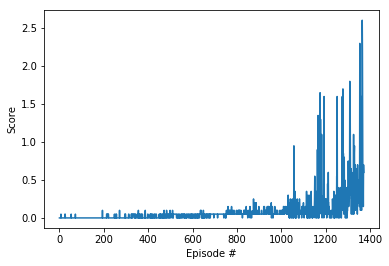

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig("resources/plot_average_of_100_episodes_batch_size_{batch_size}.png".format(batch_size=config.mini_batch_size), format="png")
plt.show()

In [19]:
rand_seed = 0
agent = Agent(config=config,
              state_size=state_size, 
              action_size=action_size, 
              num_agents=num_agents, 
              random_seed=rand_seed,
              device=torch.device('cpu'),
              actor_trained_weight_filename="checkpoint_actor.pth", 
              critic_trained_weight_filename="checkpoint_critic.pth")

scores = ddpg(agent, train_mode=False)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1036: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



Solve in 1 episodes. Average score: 0.85


In [6]:
env.close()